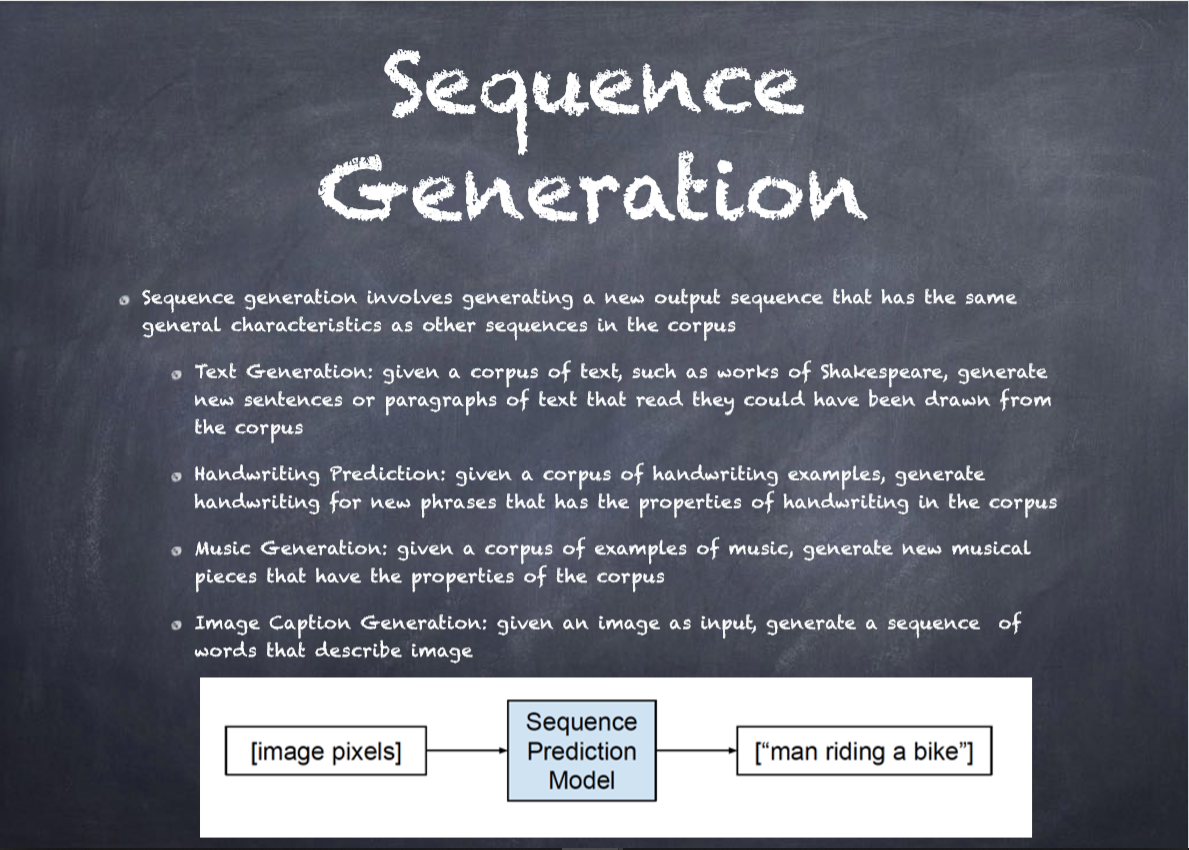

In [60]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils
import numpy as np

In [61]:
# 랜덤시드 고정
np.random.seed(5)

In [62]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [63]:
# 데이터셋 생성 함수
def seq2dataset(seq, window_size, x_dim):
    dataset_X = []
    dataset_Y = []
    for i in range(len(seq) - window_size):
        subset = seq[i:(i+ window_size + 1)]
        
        # !! 여기서 x_dim이 나중에 x_data의 feature 갯수
        for si in range(len(subset) - (x_dim-1)):
            features = code2features(subset[si])
            dataset_X.append(features)
        
        dataset_Y.append([code2idx[subset[window_size]]])
    
    return np.array(dataset_X), np.array(dataset_Y)

In [64]:
def code2features(code):
    features = []
    features.append((code2scale[code[0]])/float(max_scale_value))
    features.append(code2length[code[1]])
    return features

In [65]:
# 코드 사전 정의

code2scale = {'c':0, 'd':1, 'e':2, 'f':3, 'g':4, 'a':5, 'b':6}
code2length = {'4':0, '8':1}

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

max_scale_value = 6.0

In [66]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

In [67]:
# 2. 데이터셋 생성하기
x_train, y_train = seq2dataset(seq, window_size = 4, x_dim= 2)

In [68]:
#print(x_train)

In [69]:
#print(y_train)

In [70]:
# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (50, 4, 2))

In [71]:
# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)
# print(y_train[0])
print(len(y_train[0]))
print(y_train.shape[1])

12
12


In [72]:
one_hot_vec_size = y_train.shape[1]
print("one hot encoding vector size is", one_hot_vec_size)

one hot encoding vector size is 12


In [73]:
# 모델 구성하기
model = Sequential()
model.add(LSTM(128, batch_input_shape = (1, 4, 2), stateful =True))
model.add(Dense(one_hot_vec_size, activation='softmax'))

In [74]:
# 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [75]:
# 모델 학습
num_epochs = 1000

In [76]:
history = LossHistory() # 손실 이력 객체 생성
history.init()

In [ ]:
for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()

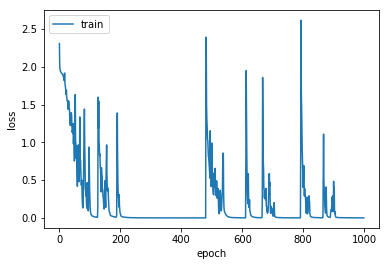

In [79]:
# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [81]:
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()

50/50 [==============================] - 0s 3ms/step
acc: 100.00%


In [82]:
# 모델 사용하기
pred_count = 50 #최대 예측 개수 정의

In [83]:
seq_out = ['g8','e8', 'e4', 'f8']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx])

print("one step prediction :", seq_out)    

one step prediction : ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


In [90]:
# 곡 전체 예측
seq_in =  ['g8','e8', 'e4', 'f8']
seq_out = seq_in

seq_in_features = []

for si in seq_in:
    features = code2features(si)
    seq_in_features.append(features)
    
for i in range(pred_count):
    sample_in = np.array(seq_in_features)
    sample_in = np.reshape(sample_in, (1, 4, 2)) # 샘플 수, 타입스텝 수, 속성 수 
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    
    features = code2features(idx2code[idx])
    seq_in_features.append(features)
    seq_in_features.pop(0)
    
model.reset_states()
print("full song prediction :", seq_out)

full song prediction : ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4']
